In [35]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [36]:
df = pd.read_csv('hsbc_twitter_DATA_not GENERAL.csv')
df.rename(columns={"NEW HUMAN CATEGORY\n 0-1000 /4000-4468 Michael\n 1000-2500 Mehmet \n 2500-4000 Aryamaan":"labels"}, inplace = True)
df.head()

,,tweet,"HUMAN CATEGORY\n ARYAMAAN:1-1000,4000-4468\n Michael-Mehmet:1000-4000",SUB CATEGORY,COMMENTS,labels,SUB CATEGORY.1,COMMENTS.1,human category (Tarun),SUB CATEGORY.2,COMMENTS.2,NEW CATEGORY,keyword,human - category,human - Sub category,Comment,HUMAN CATGEORY_NEW(ARYA),location,COMMENTS (FROM PARIJAAT),Category,Sub-category
0,2,"@LondOgrad Hello Eugene, we do apologise for t...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,delay,Delay,delay in calls,Huge Queues,customer_service_issues,"London, UK",NaN,{'category': 'Delay',subcategory': 'Delay in bounce back loan'
1,8,@ncohen4 @CooperativeBank @HSBC @HSBCUKBusines...,BAD REPUTATION,NaN,NaN,General,NaN,NaN,NaN,NaN,NaN,Bad_reputation,unhappy,{'category': 'Reputation',subcategory': 'Bad reputation',worst experience from customer – mess,BAD_REPUTATION,"Plymouth, England",NaN,{'category': 'Reputation',subcategory': 'Good reputation'
2,9,"@sharaola Good morning, sorry for your experie...",CUSTOMER_SERVICE_ISSUES,NaN,bad customer service,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,customer_service issues,customerservice,{'category': 'customer_service issues',subcategory': 'customerservice',General response from bank,General,"Cairo, Egypt",General message from hsbc,{'category': 'Reputation',subcategory': 'Good reputation'
3,11,@Bounce_BackLoan Still not a peep from HSBC,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,DELAY,Delay_in_bounce_back_loan,delay in bounce back loan,NaN,NaN,NaN,Delay_Bounceback_Loan,"delay , no response",{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays',No reply,DELAY_BOUNCEBACK_LOAN,"Enschede, Nederland",DELAY,{'category': 'Bounce back loan',subcategory': 'Bounce back loan delays'
4,15,@djm2481 @mgcmitchell @HSBC_UK Thanks for the ...,Customer Service Response,NaN,customer service reply,Customer Service Response,NaN,customer service reply,NaN,NaN,NaN,General,any queries,{'category': 'Reputation',subcategory': 'General Response from Bank (tha...,General response from bank,NaN,United Kingdom,NaN,{'category': 'Reputation',subcategory': 'Good reputation'


In [37]:
# reducing General Data 1500
drop_indices = np.random.choice(df.loc[df["labels"]=="General"].index, 1500, replace=False)
df = df.drop(drop_indices)

In [38]:
df.labels.value_counts()

General                      769
DELAY                        716
Customer Service Response    653
BAD REPUTATION               229
CUSTOMER_SERVICE_ISSUES      227
Customer Query               168
GOOD REPUTATION              101
COVID19                       50
CHURN                         37
ESG                            6
Junk                           4
Language                       2
Name: labels, dtype: int64

In [39]:
df.tweet.str.contains("bye").sum()

3

In [40]:
# label = pd.DataFrame(df.groupby("labels", as_index=False)["tweet"].apply(lambda x: " ".join(x)))
# bad_repu = label[label.labels == "BAD REPUTATION"]["reviewText"].tolist()

In [41]:
def clean_hashtag(text):
    text = text.lower()
    list_data2=[]
    
    sentence=text.split(' ')
    for word in sentence:
        if not (word.startswith('@') | word.startswith('#') | word.startswith('http')):
            list_data2.append(word)
    return " ".join([t for t in list_data2])
df.tweet=df.tweet.apply(lambda x: clean_hashtag(x))

In [42]:
# df.tweet[df.tweet.str.contains("#")].tolist()

In [43]:
import string
def remove_punc(txt):
    txt = " ".join([c for c in txt if c not in string.punctuation])
    txt = txt.replace("\n", " ")
    return txt
df.tweet = df.tweet.apply(lambda x: remove_punc(x))

In [44]:
"coming" in nltk.corpus.words.words()

True

In [45]:
def remove_noneng(sent):
    words = set(nltk.corpus.words.words())
    junk = []
    junk.append(" ".join(w for w in nltk.wordpunct_tokenize(sent) if w not in words))
    print(junk)
    return  " ".join(w for w in nltk.wordpunct_tokenize(sent) if w in words)

df.tweet=df.tweet.apply(lambda x: remove_noneng(x))

['']
['']
['']
['ð ÿ ™ ‚ ð ÿ ‘ \x8d']
['']
['']
['1 2']
['']
['â € ™']
['']
['â € ™ â € ™']
['']
['6 â € ™']
['2 0 2 0 2 0 2 3']
['â € ™']
['']
['2 4 4 2']
['']
['â € ™ 6 ð ÿ ˜ ©']
['â € ™ 2 0 â € ™ 4 0']
['']
['8 0 0 9 7 5 4 7 2 2']
['â € ™']
['']
['']
['â € ˜ â € ™']
['â € ™ 4']
['5']
['']
['2 7 5 â £ 3 6 0 0 1 ð ÿ ˜ ¬ ð ÿ ‘ \x8d ð ÿ \x8f ¼']
['â € ™ â € ™']
['']
['â € ™ 2 0 0 8']
['']
['']
['']
['']
['4 8']
['']
['ð ÿ ™ \x8f ð ÿ \x8f »']
['0 3 4 5 6 0 0 2 2 9 0 0 3 4 5 7 4 0 4 4 0 4 ð ÿ ˜ š']
['']
['â € ™ â € ™']
['']
['']
['']
['']
['ð ÿ ‘ \x8d']
['2 1 2']
['']
['ð ÿ ¤ · ð ÿ \x8f » â € \x8d â ™ ‚ ï ¸ \x8f â € ™']
['5']
['1 2']
['1 8']
['â € ™ 3 2 â € ™']
['']
['']
['â € ™']
['ð ÿ – \x90 â € ™']
['']
['']
['2 4 â € ™ â € ™ â € ™ 2']
['']
['ð ÿ ™ „']
['']
['ð ÿ ˜ ‚ ð ÿ ˜ \xad']
['']
['']
['â € ™']
['ð ÿ ˜ ‚ ð ÿ ˜ ‚']
['1 0 ð ÿ ¤ ¦ â € \x8d â ™ € ï ¸ \x8f ð ÿ ™ ˆ']
['â € ™ â € ™']
['ð ÿ ¤ ¦ ð ÿ \x8f » â € \x8d â ™ ‚ ï ¸ \x8f ð ÿ ˜ ¢']
['']
['']
['']
['1 0 ð ÿ ˜ ž']
['']
['']
['â € ™']

In [ ]:
df.tweet.

In [13]:
remove_noneng("ali qwertyuı ırmak yes coming apologise going")

['ali qwertyuı ırmak apologise']


'yes coming going'

In [10]:
replace_word = {"covid":"covid", "corona":"covid", "bouncebackloan":"bounce back loan",
                "noresponse":"no response","customers":"customer", "bounceback":"bounce back",
                "backloan":"back loan","on hold":"on_hold", "bbl":"bounce back loan",
                "pandemi":"covid", "any news":"any_news","give up":"give_up", "gave up":"give_up",
                "well done":"well_done"}
for key, value in replace_word.items():
    df.tweet.replace(f"\S*{key}\S*" , f"{value}", regex=True, inplace = True)

In [11]:
junk_words = "nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [12]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', text)
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [13]:
def clean_data(text, small_word_lmt=0, extra_words=junk_words_list,replace_word=replace_word):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        if not word.startswith('http') \
           and word.isalpha() \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.tweet = df.tweet.apply(lambda x: clean_data(x))

In [14]:
df.tweet.str.contains("worst").sum()

67

In [45]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        if token.text=="worst" or token.text=="worse":
            lemma = token.text
        else:
            lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
    return " ".join(list_data3)
# df.tweet = df.tweet.apply(lambda x: word_root(x))  

In [47]:
word_root("apologise")

'apologise'

In [17]:
word_root("worst")

'worst'

In [18]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [19]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in df.tweet])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(10)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [20]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [21]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [22]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [23]:
bigrams

['can not',
 'stay safe',
 'absolute joke',
 'live chat',
 'hence request',
 'full name',
 'information hence',
 'have nt',
 'direct message',
 'refer link',
 'post code',
 'order assist',
 'click link',
 'credit card',
 'name post',
 'concerned team',
 'link below',
 'that s',
 'what s',
 'customer care',
 'let know',
 'mobile number',
 'sorry hear',
 'send register',
 'good morning',
 'bounce back',
 'team touch',
 'customer service',
 'worst customer',
 'back loan',
 'need information',
 'assist need',
 'please click',
 'set feeder',
 'feeder account',
 'thank write',
 'request call',
 'still wait',
 'personal account',
 'hello sorry',
 'still nothing',
 'call phone',
 'business bounce',
 'business account',
 'I think',
 'hello thank',
 'please send',
 'apply feeder',
 'apply bounce',
 'call back',
 'I want',
 'please help',
 'I hope',
 'wait day',
 'I speak',
 'account bounce',
 'I apply',
 'I know',
 'I need',
 'I see',
 'I tell',
 'I try',
 'I receive',
 'hello I',
 'I send',
 'I

In [24]:
trigrams

['connect minute person',
 'regret every second',
 'minute person set',
 'absolute joke worst',
 'regard concern refer',
 'mobile number fetch',
 'fetch send concerned',
 'information hence request',
 'work quickly possible',
 'digit complaint number',
 'call connect minute',
 'register mobile number',
 'name post code',
 'concern refer link',
 'phone regard concern',
 'full name post',
 'experience business life',
 'write order assist',
 'need information hence',
 'second call connect',
 'send register mobile',
 'kindly write concern',
 'click link below',
 'team check priority',
 'joke worst customer',
 'hence request call',
 'person set feeder',
 'provide full name',
 'order assist need',
 'every second call',
 'direct message link',
 'message link below',
 'worst customer experience',
 'concern team touch',
 'number fetch send',
 'kindly send register',
 'scam please click',
 'concerned team check',
 'assist refer link',
 'life I regret',
 'look help accordingly',
 'team assist ref

In [25]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "name post code":"name_post_code","full name":"full_name",
                  "credit card":"credit_card","click link below":"click_link_below","worst customer experience":"worst_customer_experience",
                  "thank respond back":"thank_respond_back","phone service team":"phone_service_team",
                  "thank write back":"thank_write_back","feeder account":"feeder_account", "still wait":"still_wait",
                  "business account":"business_account","business customer":"business_customer","good morning":"good_morning",
                  "week ago":"week_ago","post code":"post_code","click link":"click_link","let know":"let_know",
                  "call back":"call_back","personal account":"personal_account","refer link":"refer_link","link below":"link_below",
                  "name post":"name_post","hear nothing":"hear_nothing","sorry hear":"sorry_hear", "hello thank":"hello_thank",
                  "loan application":"loan_application","loan apply":"loan_apply"}
for key, value in replace_ngrams.items():
        df.tweet.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [26]:
df.tweet.str.contains("worst").sum()

67

In [27]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.tweet.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [28]:
df.drop(df[df.tweet.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [29]:
df_clean = df.tweet
df_clean.shape

(2967,)

In [30]:
df_clean = df_clean.dropna()
df_clean.shape

(2967,)

In [31]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [34]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [35]:
# embeddings1[embeddings1.argmax()]

In [36]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/93 [00:00<?, ?it/s]

In [37]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [38]:
import umap

In [39]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [40]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [41]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [42]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [43]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.0066008952371870155

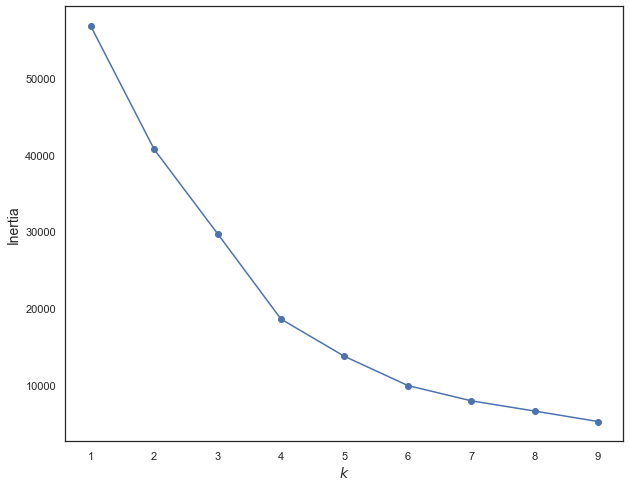

In [44]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [45]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [46]:
clustering_result = cluster_results()

In [47]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 730, 1: 1012, 2: 548, 3: 677}


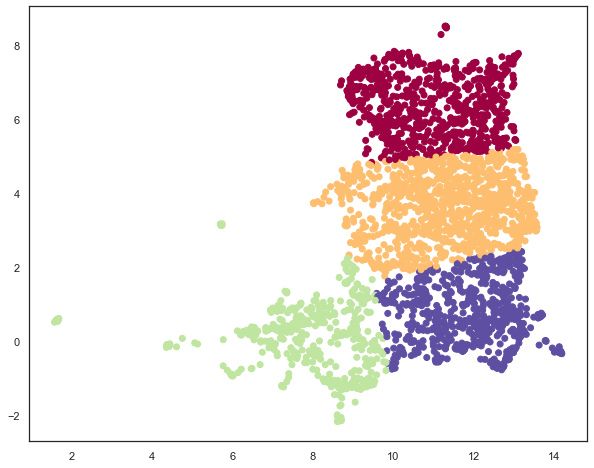

----------UMAP_bert1_hdbscan--------------------
{-1: 65, 0: 33, 1: 34, 2: 2835}


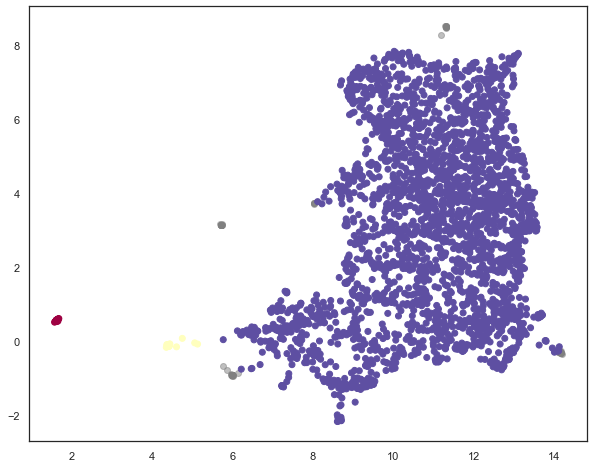

----------UMAP_bert1_norm--------------------
{0: 632, 1: 1077, 2: 1229, 3: 29}


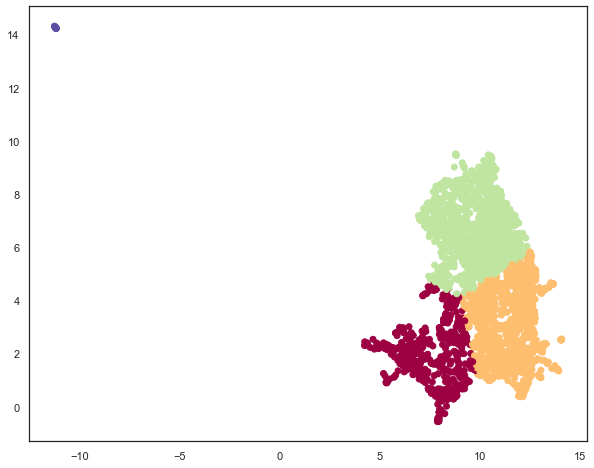

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 1421, 0: 39, 1: 162, 2: 116, 3: 41, 4: 36, 5: 222, 6: 181, 7: 58, 8: 20, 9: 609, 10: 30, 11: 32}


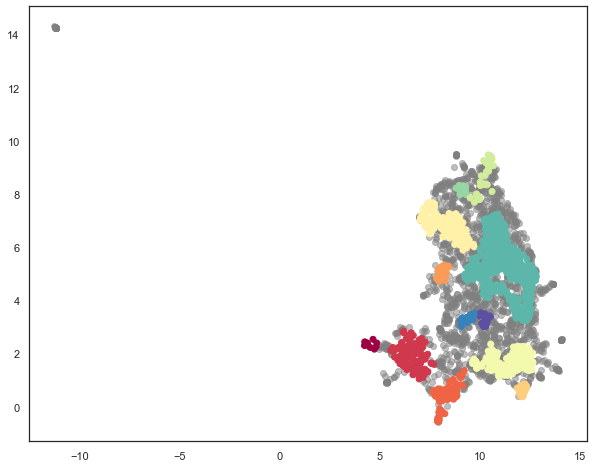

----------UMAP_bert2--------------------
{0: 1423, 1: 1483, 2: 32, 3: 29}


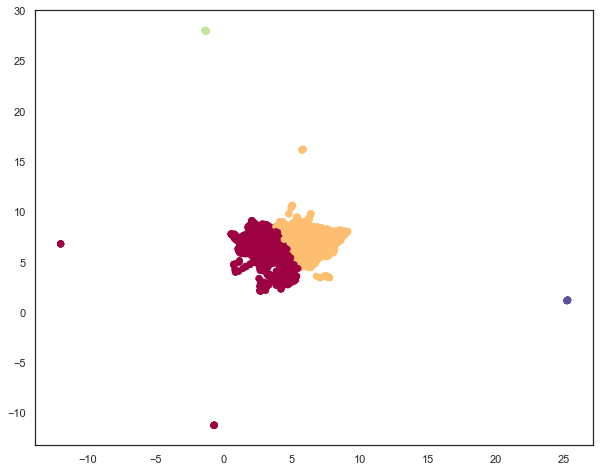

----------UMAP_bert2_hdbscan--------------------
{-1: 44, 0: 32, 1: 2891}


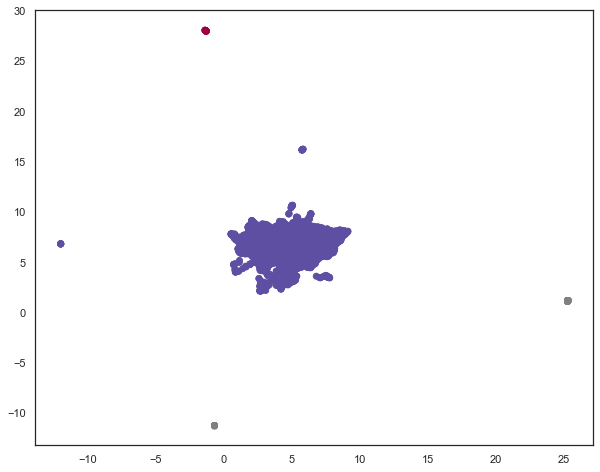

----------UMAP_bert2_norm--------------------
{0: 1218, 1: 32, 2: 1226, 3: 491}


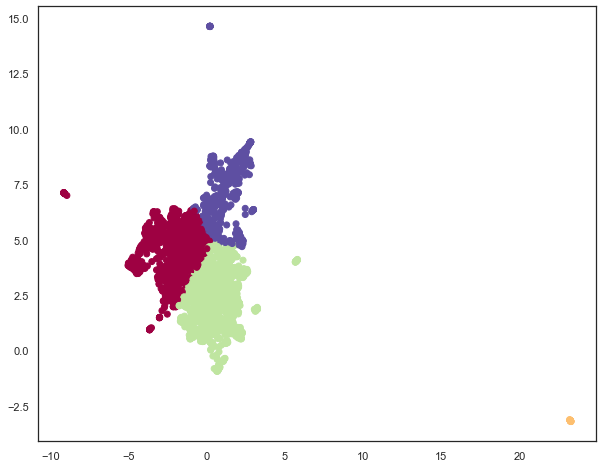

----------UMAP_bert2_norm_hdbscan--------------------
{0: 32, 1: 2935}


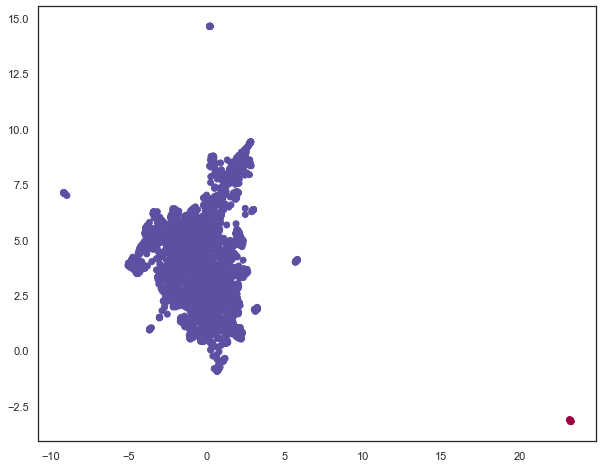

----------PCA_bert1--------------------
{0: 1070, 1: 498, 2: 876, 3: 523}


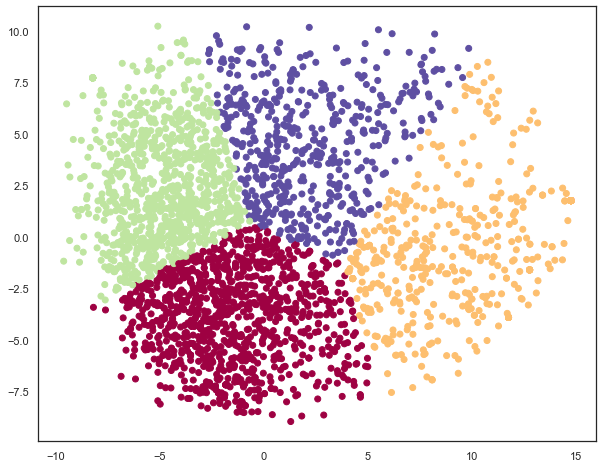

----------PCA_bert1_hdbscan--------------------
{-1: 558, 0: 71, 1: 39, 2: 2299}


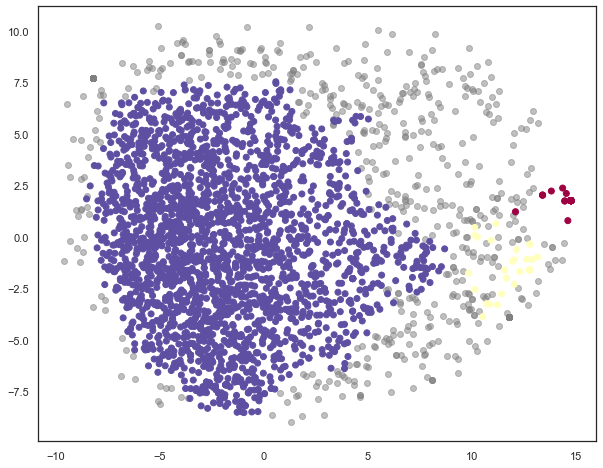

----------PCA_bert1_norm--------------------
{0: 1064, 1: 516, 2: 520, 3: 867}


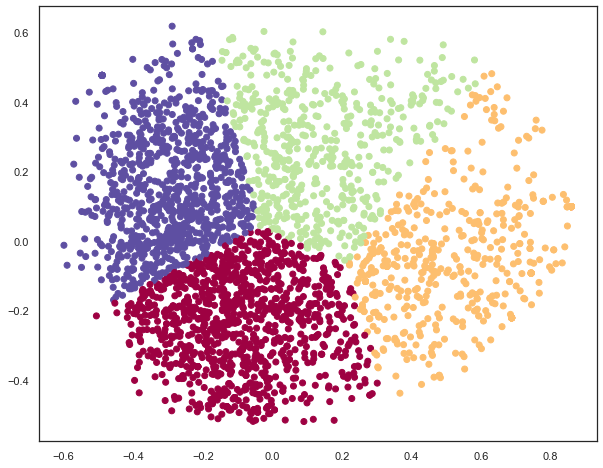

----------PCA_bert1_norm_hdbscan--------------------
{-1: 66, 0: 16, 1: 2885}


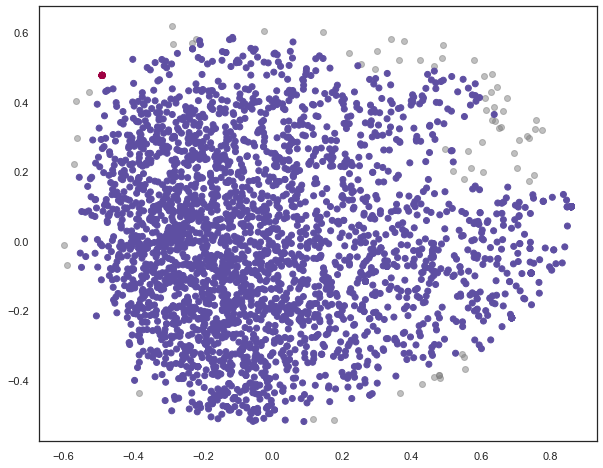

----------PCA_bert2--------------------
{0: 369, 1: 944, 2: 1593, 3: 61}


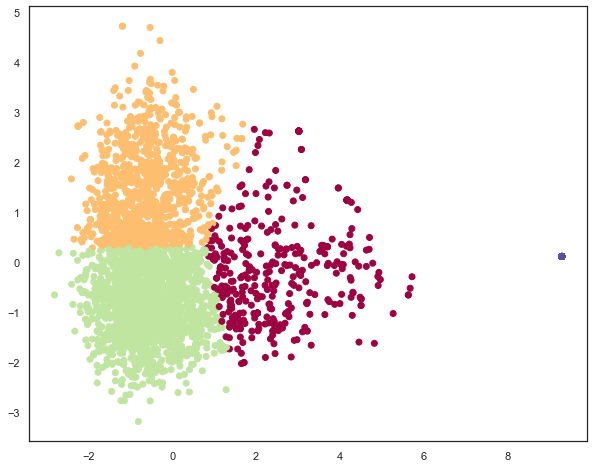

----------PCA_bert2_hdbscan--------------------
{0: 61, 1: 2906}


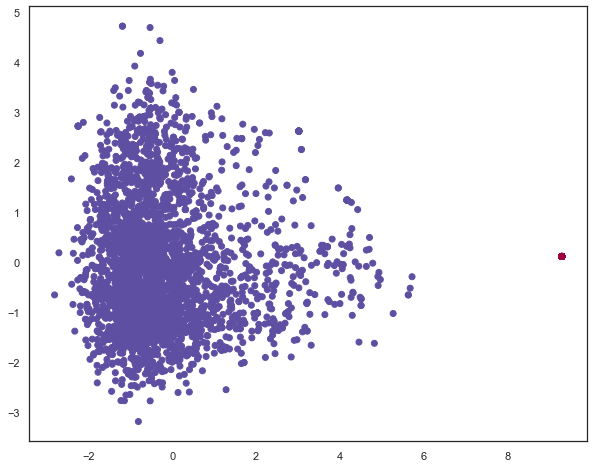

----------PCA_bert2_norm--------------------
{0: 814, 1: 1215, 2: 696, 3: 242}


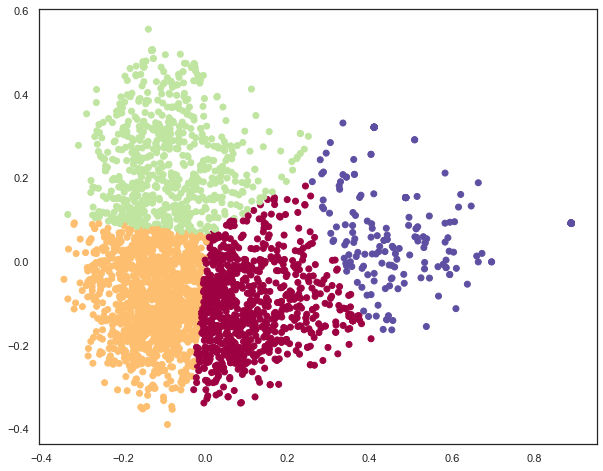

----------PCA_bert2_norm_hdbscan--------------------
{0: 61, 1: 2906}


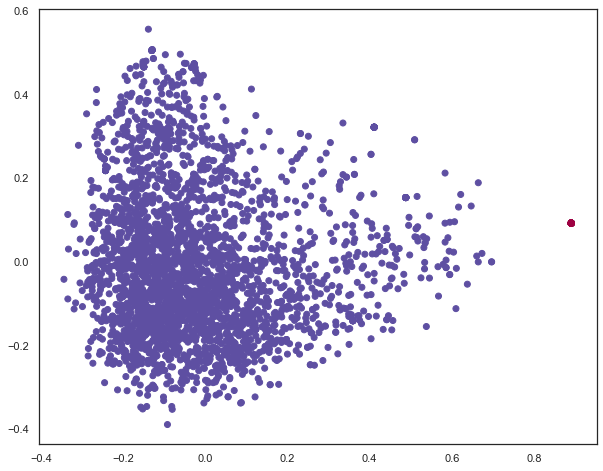

----------tSNE_bert1--------------------
{0: 781, 1: 737, 2: 730, 3: 719}


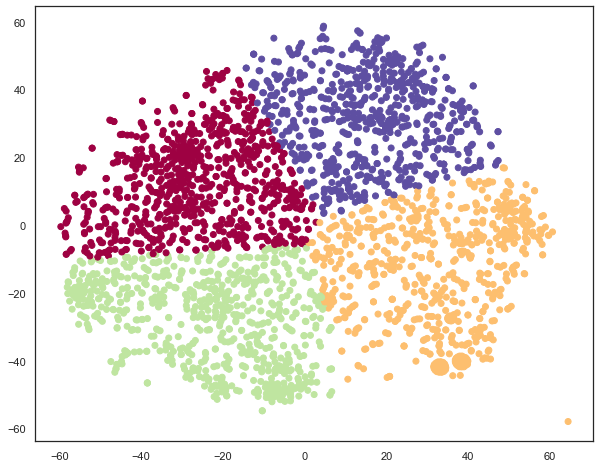

----------tSNE_bert1_hdbscan--------------------
{-1: 1592, 0: 200, 1: 45, 2: 113, 3: 292, 4: 36, 5: 19, 6: 76, 7: 78, 8: 86, 9: 51, 10: 305, 11: 74}


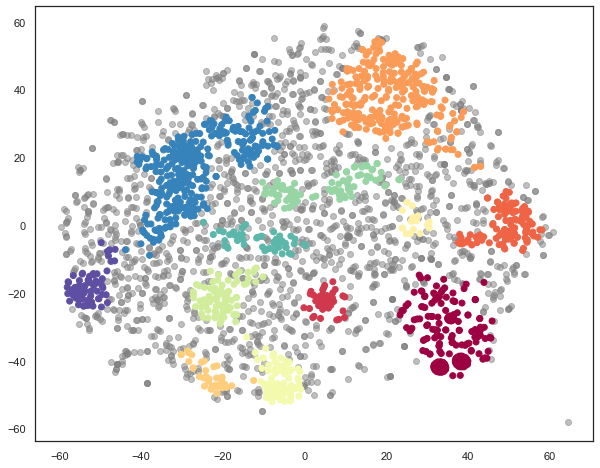

----------tSNE_bert1_norm--------------------
{0: 693, 1: 739, 2: 764, 3: 771}


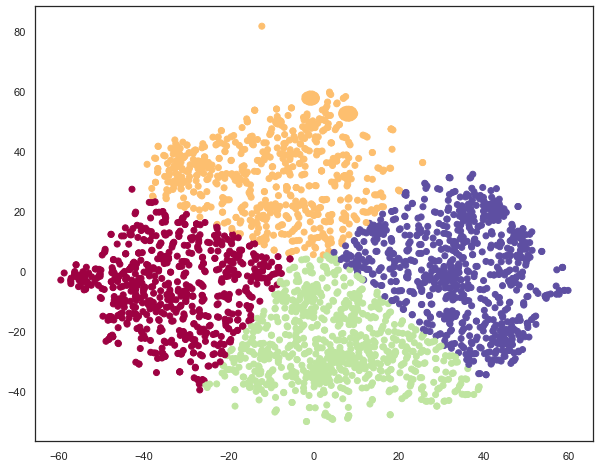

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 929, 0: 1849, 1: 116, 2: 19, 3: 54}


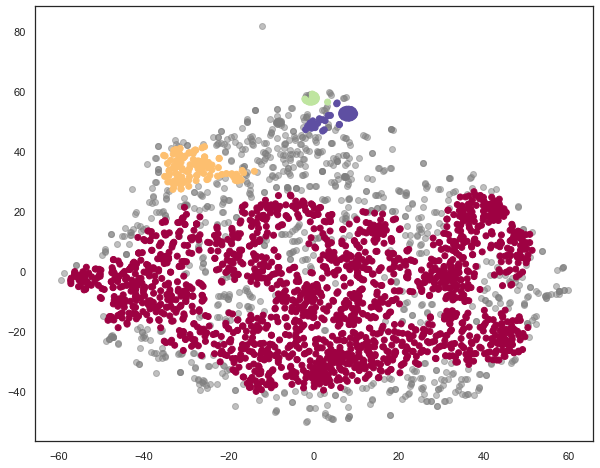

----------tSNE_bert2--------------------
{0: 867, 1: 571, 2: 712, 3: 817}


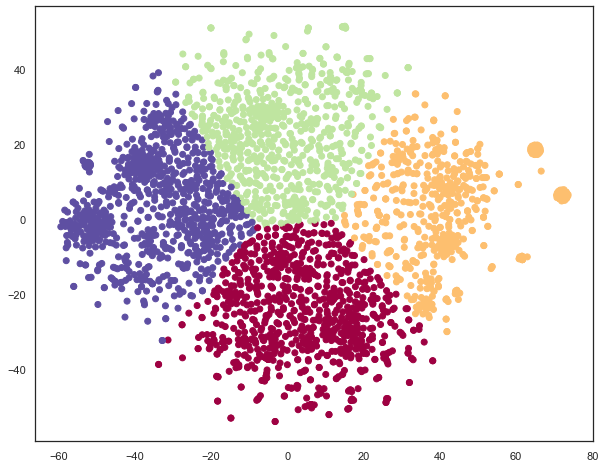

----------tSNE_bert2_hdbscan--------------------
{-1: 100, 0: 45, 1: 2822}


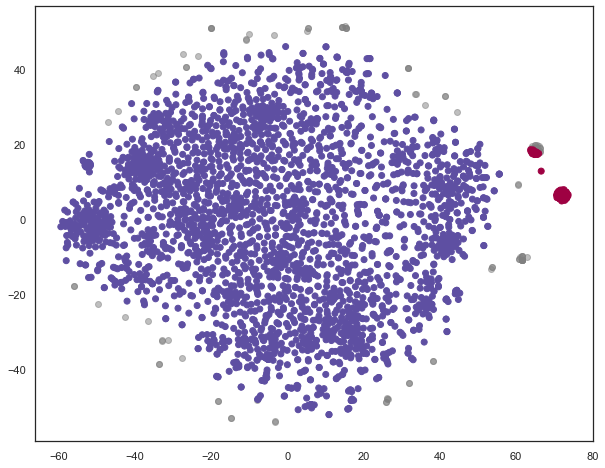

----------tSNE_bert2_norm--------------------
{0: 722, 1: 650, 2: 913, 3: 682}


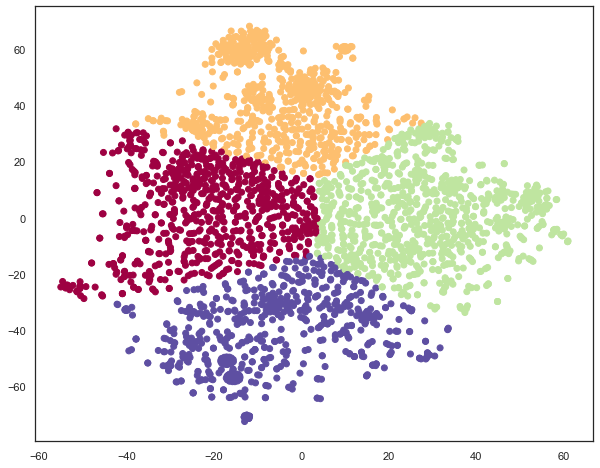

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 1256, 0: 138, 1: 109, 2: 57, 3: 18, 4: 1337, 5: 52}


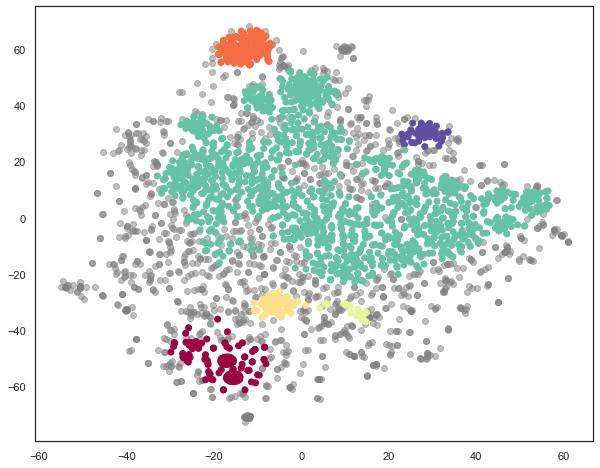

In [48]:
plot()

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [50]:
def cluster_words(clustering_result=clustering_result, top_n = 20, show_cross = False):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})

        try : 
            del labeled_docs_try
        except :
            pass
        labeled_docs_try =pd.DataFrame(df_clean)
        labeled_docs_try["labels"] = df.labels
        labeled_docs_try["cluster"] = docs.cluster
        labeled_docs_try.head(50)
        cross = pd.crosstab(labeled_docs_try.labels, labeled_docs_try.cluster)
        if show_cross:
            display(cross)
        else: pass
                
        tfidf_vec = TfidfVectorizer()
        tfidf_mat = tfidfmatrix(labeled_docs.tweet, tfidf_vec)
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
        most_common.index = np.unique(cluster)
        display(most_common)

In [51]:
cluster_words(show_cross = True)

====================================UMAP_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,140,56,14,19
CHURN,19,9,4,5
COVID19,7,21,15,7
CUSTOMER_SERVICE_ISSUES,84,93,21,29
Customer Query,25,75,30,38
Customer Service Response,51,107,75,420
DELAY,213,426,53,24
ESG,2,1,1,2
GOOD REPUTATION,26,13,28,34


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,feeder_account,nothing,apply,worst_customer_experience,bounce_back_loan,account,worst,day,still,say,call,help,customer,service,back,business,never,time,wait,try
1,bounce_back_loan,feeder_account,still_wait,apply,day,account,business_account,good_morning,still,wait,back,thank,time,please,application,money,credit_card,business,say,tell
2,thank,hello,send,please,check,number,priority,help,join,team,apply,back,know,application,good,new,kindly,concerned,fetch,covid
3,hello_thank,thank,full_name,hello,please,refer_link,team,send,call,help,sorry_hear,click_link,link_below,thank_write_back,write,need,click_link_below,message,name_post_code,number


====================================UMAP_bert1_hdbscan=============================================


cluster,-1,0,1,2
labels,,,,
BAD REPUTATION,2,0,1,226
CHURN,0,0,0,37
COVID19,4,0,0,46
CUSTOMER_SERVICE_ISSUES,0,0,0,227
Customer Query,0,0,0,168
Customer Service Response,32,0,0,621
DELAY,0,1,2,713
ESG,0,0,0,6
GOOD REPUTATION,0,1,0,100


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,hello_thank,refer_link,assist,send,team,call,phone,request,hence,information,join,kindly,need,order,write,gold,mobile,number,check,concerned
0,power,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access
1,another,difference,loan,pende,link,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept
2,thank,bounce_back_loan,feeder_account,apply,please,account,hello,hello_thank,day,still_wait,time,wait,still,help,full_name,application,say,back,call,business


====================================UMAP_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,19,36,173,1
CHURN,6,5,26,0
COVID19,19,12,19,0
CUSTOMER_SERVICE_ISSUES,29,61,137,0
Customer Query,32,84,52,0
Customer Service Response,114,473,66,0
DELAY,79,151,486,0
ESG,1,2,3,0
GOOD REPUTATION,38,34,29,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,hello,day,help,today,please,back,happy,time,apply,wait,know,well,covid,good,hope,new,application,join,make
1,hello_thank,thank,hello,full_name,please,feeder_account,account,send,team,refer_link,call,help,credit_card,apply,need,number,sorry_hear,bounce_back_loan,back,day
2,bounce_back_loan,feeder_account,still_wait,apply,day,still,account,nothing,wait,business_account,back,time,say,business,application,call,please,help,money,tell
3,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible


====================================UMAP_bert1_norm_hdbscan=============================================


cluster,-1,0,1,2,3,4,5,6,7,8,9,10,11
labels,,,,,,,,,,,,,
BAD REPUTATION,142,0,8,2,2,0,30,2,13,2,28,0,0
CHURN,13,0,1,1,0,0,10,1,1,2,7,0,1
COVID19,30,0,4,3,0,0,1,0,0,0,10,0,2
CUSTOMER_SERVICE_ISSUES,119,0,15,1,4,0,16,6,5,3,56,2,0
Customer Query,76,0,13,0,0,0,12,4,1,0,59,2,1
Customer Service Response,353,0,5,31,2,36,7,135,4,1,44,21,14
DELAY,264,3,27,4,31,0,101,3,6,7,265,1,4
ESG,3,0,0,1,0,0,0,0,1,0,0,0,1
GOOD REPUTATION,36,1,6,16,0,0,1,11,18,0,10,1,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,hello_thank,thank,hello,feeder_account,full_name,call,refer_link,please,wait,account,send,team,day,apply,phone,say,help,money,try,new
0,power,difference,pende,point,loan,another,link,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic
1,anyone,send,back,apply,exclusive,know,application,sport,let_know,bounce,complaint,yes,same,please,shanghai,stadium,response,speak,answer,spark
2,thank,happy,good,help,zar,value,well,great,luck,welcome,day,glad,bless,generous,vigilant,feedback,support,na,nice,time
3,still_wait,still,apply,wait,sign,arena,park,call,why,hello,breath,call_back,keep,please,require,bounce,say,back,time,assistance
4,full_name,link_below,name_post_code,click_link_below,please,thank,check,hello,look,send,let,accordingly,message,direct,sorry_hear,start,ill,share,post_code,help
5,nothing,apply,never,still,say,feeder_account,day,application,wait,account,anyone,can,not,back,receive,absolutely,send,anything,personal_account,tell
6,hello_thank,thank,please,sorry_hear,team,hello,thank_write_back,refer_link,kindly,message,write,help,send,let_know,click_link,inconvenience,share,request,call,patience
7,worst_customer_experience,feeder_account,bounce_back_loan,minute,person,every,joke,regret,life,absolute,connect,business,set,call,second,worst,credit_card,fossil,fuel,customer
8,ago,behind,help,awful,poor,fall,still_wait,know,need,bye,difficult,day,bloody,work,act,nothing,useless,word,worse,apply


====================================UMAP_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,91,137,0,1
CHURN,16,21,0,0
COVID19,9,41,0,0
CUSTOMER_SERVICE_ISSUES,136,91,0,0
Customer Query,77,91,0,0
Customer Service Response,568,85,0,0
DELAY,133,582,1,0
ESG,1,5,0,0
GOOD REPUTATION,56,45,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,hello_thank,hello,full_name,please,send,team,call,help,refer_link,number,phone,time,sorry_hear,today,click_link,link_below,day,good_morning,assist
1,bounce_back_loan,feeder_account,apply,account,day,still_wait,application,wait,back,business,business_account,still,credit_card,money,say,thank,time,nothing,please,help
2,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
3,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible


====================================UMAP_bert2_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,1,0,228
CHURN,0,0,37
COVID19,0,0,50
CUSTOMER_SERVICE_ISSUES,0,0,227
Customer Query,0,0,168
Customer Service Response,0,0,653
DELAY,0,1,715
ESG,0,0,6
GOOD REPUTATION,0,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,join,these,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted
0,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
1,thank,bounce_back_loan,hello_thank,feeder_account,hello,apply,please,account,day,help,call,back,send,still_wait,time,wait,still,team,full_name,application


====================================UMAP_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,95,0,87,47
CHURN,22,0,9,6
COVID19,29,0,14,7
CUSTOMER_SERVICE_ISSUES,53,0,142,32
Customer Query,55,0,97,16
Customer Service Response,58,0,544,51
DELAY,577,1,81,57
ESG,4,0,1,1
GOOD REPUTATION,39,0,40,22


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,feeder_account,apply,still_wait,account,day,application,business_account,wait,business,still,back,say,nothing,time,money,take,personal_account,receive,tell
1,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
2,hello_thank,thank,full_name,hello,please,credit_card,send,team,call,help,refer_link,number,sorry_hear,click_link,link_below,need,name_post_code,let_know,customer,phone
3,good_morning,thank,day,today,happy,good,still,morning,assist,join,nothing,see,time,same,back,digital,help,new,music,anyone


====================================UMAP_bert2_norm_hdbscan=============================================


cluster,0,1
labels,,
BAD REPUTATION,0,229
CHURN,0,37
COVID19,0,50
CUSTOMER_SERVICE_ISSUES,0,227
Customer Query,0,168
Customer Service Response,0,653
DELAY,1,715
ESG,0,6
GOOD REPUTATION,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
1,thank,bounce_back_loan,hello_thank,feeder_account,hello,apply,please,account,day,help,call,back,send,still_wait,time,wait,still,team,full_name,application


====================================PCA_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,33,17,98,81
CHURN,5,4,12,16
COVID19,12,15,14,9
CUSTOMER_SERVICE_ISSUES,50,24,108,45
Customer Query,77,21,48,22
Customer Service Response,502,45,79,27
DELAY,158,55,333,170
ESG,2,1,3,0
GOOD REPUTATION,46,22,27,6


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,hello_thank,thank,hello,full_name,please,feeder_account,send,team,help,refer_link,account,call,bounce_back_loan,good_morning,apply,back,click_link,link_below,number,assist
1,thank,join,hello,please,good,apply,happy,covid,still,today,wealth,help,know,receive,anyone,back,same,well,see,time
2,bounce_back_loan,feeder_account,apply,account,day,business_account,business,call,wait,worst_customer_experience,still,still_wait,say,time,back,money,credit_card,application,nothing,help
3,still_wait,apply,nothing,still,day,feeder_account,say,wait,back,time,application,be,tell,service,please,worst,think,give,help,see


====================================PCA_bert1_hdbscan=============================================


cluster,-1,0,1,2
labels,,,,
BAD REPUTATION,58,2,0,169
CHURN,15,0,0,22
COVID19,3,0,0,47
CUSTOMER_SERVICE_ISSUES,44,0,0,183
Customer Query,25,0,3,140
Customer Service Response,65,0,1,587
DELAY,111,1,2,602
ESG,2,0,0,4
GOOD REPUTATION,44,0,2,55


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,bounce_back_loan,thank,worst_customer_experience,feeder_account,nothing,apply,day,help,business,customer,worst,call,hello,every,set,still,back,life,money,service
0,tell,ever,honestly,oh,point,yeah,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate
1,join,dow,good,know,answer,hello,thank,ana,assume,exclusive,lucky,might,moment,potential,suspect,upside,access,another,approve,be
2,hello_thank,bounce_back_loan,thank,feeder_account,apply,account,hello,day,please,back,help,still_wait,call,send,time,wait,full_name,still,team,application


====================================PCA_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,32,18,80,99
CHURN,5,4,16,12
COVID19,12,15,9,14
CUSTOMER_SERVICE_ISSUES,50,24,46,107
Customer Query,77,22,22,47
Customer Service Response,498,52,26,77
DELAY,160,58,170,328
ESG,2,1,0,3
GOOD REPUTATION,45,23,6,27


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,hello_thank,thank,hello,full_name,please,feeder_account,bounce_back_loan,send,team,account,help,refer_link,call,good_morning,back,apply,click_link,number,link_below,assist
1,thank,hello,join,please,good,apply,happy,know,still,today,covid,day,help,time,well,wealth,back,receive,same,anyone
2,still_wait,apply,nothing,still,day,say,feeder_account,wait,back,time,application,be,tell,please,service,worst,think,give,see,help
3,bounce_back_loan,feeder_account,apply,business_account,account,day,business,wait,call,worst_customer_experience,still,still_wait,say,time,back,money,credit_card,application,nothing,help


====================================PCA_bert1_norm_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,18,0,211
CHURN,3,0,34
COVID19,0,0,50
CUSTOMER_SERVICE_ISSUES,5,0,222
Customer Query,1,0,167
Customer Service Response,9,0,644
DELAY,12,0,704
ESG,0,0,6
GOOD REPUTATION,2,16,83


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,worst,help,bounce_back_loan,apply,hello_thank,customer,day,happy,money,please,thank,ever,nothing,receive,still,absolutely,account,ago,anything,good_morning
0,feeder_account,worst_customer_experience,bounce_back_loan,absolute,call,connect,joke,life,minute,regret,set,business,every,person,second,abandon,abigail,ability,aboard,about
1,thank,hello_thank,hello,apply,please,feeder_account,account,bounce_back_loan,day,still_wait,full_name,say,help,back,send,call,time,wait,still,business_account


====================================PCA_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,29,39,160,1
CHURN,3,6,28,0
COVID19,14,0,36,0
CUSTOMER_SERVICE_ISSUES,14,69,144,0
Customer Query,13,74,81,0
Customer Service Response,17,529,107,0
DELAY,36,80,599,1
ESG,0,2,4,0
GOOD REPUTATION,8,48,45,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,thank,join,covid,good,well,asset,growth,wealth,new,see,bad,sport,happy,off,still,time,today,price,bounce_back_loan,day
1,hello_thank,thank,hello,please,full_name,send,help,team,sorry_hear,refer_link,call,credit_card,number,name_post_code,sorry,phone,assist,link_below,request,write
2,feeder_account,bounce_back_loan,account,apply,day,still_wait,application,business_account,still,back,wait,business,time,take,nothing,say,money,receive,customer,tell
3,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible


====================================PCA_bert2_hdbscan=============================================


cluster,0,1
labels,,
BAD REPUTATION,1,228
CHURN,0,37
COVID19,0,50
CUSTOMER_SERVICE_ISSUES,0,227
Customer Query,0,168
Customer Service Response,0,653
DELAY,1,715
ESG,0,6
GOOD REPUTATION,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
1,thank,bounce_back_loan,hello_thank,feeder_account,hello,apply,please,account,day,help,call,back,send,still_wait,time,wait,still,team,full_name,application


====================================PCA_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,89,114,10,16
CHURN,17,16,4,0
COVID19,44,5,0,1
CUSTOMER_SERVICE_ISSUES,46,140,35,6
Customer Query,31,77,52,8
Customer Service Response,48,121,475,9
DELAY,152,511,39,14
ESG,5,0,1,0
GOOD REPUTATION,25,44,27,5


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,covid,time,gold,nothing,back,day,market,new,still,money,thank,be,see,apply,take,nt,think,know,say
1,bounce_back_loan,feeder_account,apply,account,day,wait,still_wait,application,business_account,time,call,back,still,thank,say,nothing,business,customer,receive,take
2,hello_thank,thank,hello,full_name,please,refer_link,send,call,team,link_below,sorry_hear,help,name_post_code,number,credit_card,good_morning,call_back,kindly,message,let_know
3,thank,join,good,happy,well,same,yes,worst,spark,sport,stadium,bad,hello,luck,oh,tell,too,chance,mate,national


====================================PCA_bert2_norm_hdbscan=============================================


cluster,0,1
labels,,
BAD REPUTATION,1,228
CHURN,0,37
COVID19,0,50
CUSTOMER_SERVICE_ISSUES,0,227
Customer Query,0,168
Customer Service Response,0,653
DELAY,1,715
ESG,0,6
GOOD REPUTATION,0,101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access,accessible
1,thank,bounce_back_loan,hello_thank,feeder_account,hello,apply,please,account,day,help,call,back,send,still_wait,time,wait,still,team,full_name,application


====================================tSNE_bert1=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,65,21,127,16
CHURN,7,7,21,2
COVID19,12,23,8,7
CUSTOMER_SERVICE_ISSUES,79,31,82,35
Customer Query,72,44,17,35
Customer Service Response,44,101,52,456
DELAY,319,112,244,41
ESG,3,1,1,1
GOOD REPUTATION,11,39,25,26


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,feeder_account,account,apply,business_account,day,credit_card,back,money,please,say,application,still,thank,time,wait,personal_account,help,business,tell
1,thank,hello,still_wait,please,back,time,help,still,day,apply,wait,today,good,know,new,well,say,covid,join,same
2,feeder_account,apply,nothing,worst_customer_experience,still_wait,bounce_back_loan,still,day,wait,worst,customer,call,say,account,service,business,time,never,people,application
3,hello_thank,full_name,thank,hello,please,team,refer_link,send,good_morning,link_below,call,help,sorry_hear,name_post_code,kindly,number,thank_write_back,assist,write,click_link_below


====================================tSNE_bert1_hdbscan=============================================


cluster,-1,0,1,2,3,4,5,6,7,8,9,10,11
labels,,,,,,,,,,,,,
BAD REPUTATION,143,5,2,0,1,14,0,9,12,1,4,20,18
CHURN,21,0,0,0,1,2,0,5,1,1,0,5,1
COVID19,45,1,0,1,0,0,0,0,0,0,0,3,0
CUSTOMER_SERVICE_ISSUES,152,8,4,0,10,2,0,3,9,7,4,17,11
Customer Query,105,6,1,5,1,0,0,4,1,6,0,36,3
Customer Service Response,304,6,0,32,247,1,9,2,5,30,1,11,5
DELAY,354,18,35,4,3,7,3,26,45,21,35,157,8
ESG,2,0,0,1,0,0,0,0,0,1,0,1,1
GOOD REPUTATION,45,3,0,17,12,0,0,1,0,2,1,2,18


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,hello_thank,account,hello,day,feeder_account,apply,need,wait,please,call,money,say,send,new,help,team,today,back,time
0,join,let_know,stadium,oh,chance,mate,national,price,sport,apply,answer,sign,target,dow,leant,someone,team,yes,application,know
1,still_wait,still,apply,wait,why,personal_account,arena,park,anybody,breath,call,sign,call_back,application,bounce,give,long,back,time,keep
2,thank,hello,help,happy,good,great,please,na,appreciate,support,luck,especially,feedback,welcome,bless,generous,well,glad,lucky,thought
3,hello_thank,full_name,refer_link,link_below,sorry_hear,thank,name_post_code,hello,please,team,kindly,send,click_link,write,message,click_link_below,request,thank_write_back,assist,call
4,worse,bad,disgrace,reason,hear_nothing,fail,still_wait,awful,bloody,sadly,whole,stress,terrible,act,together,worst,apply,tell,lot,move
5,shortly,thank,next,matter,ease,phase,update,request,once,soon,revert,review,number,amount,hello,assist,application,share,academic,courage
6,nothing,absolutely,decline,least,still,apply,basically,consider,zero,application,elsewhere,nowhere,bud,non,seem,turn,worst,let,card,leave
7,nothing,never,day,apply,still,still_wait,feeder_account,personal_account,wait,account,say,send,team,nt,business_account,last,should,call,today,try
8,good_morning,day,morning,work,receive,business,apply,yesterday,bounce,quickly,back,possible,feeder_account,thank,today,hello,new,fund,account,say


====================================tSNE_bert1_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,13,25,55,136
CHURN,2,7,7,21
COVID19,8,23,11,8
CUSTOMER_SERVICE_ISSUES,33,31,72,91
Customer Query,39,42,71,16
Customer Service Response,450,95,63,45
DELAY,30,100,312,274
ESG,1,1,3,1
GOOD REPUTATION,25,40,11,25


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,hello_thank,thank,full_name,hello,please,team,refer_link,send,good_morning,call,link_below,sorry_hear,help,number,click_link,thank_write_back,assist,kindly,click_link_below,account
1,thank,hello,please,help,back,time,new,still,day,apply,know,well,today,wait,good,money,say,covid,same,try
2,bounce_back_loan,feeder_account,account,apply,business_account,day,credit_card,application,thank,back,please,money,say,still,wait,help,personal_account,time,business,hello
3,still_wait,feeder_account,apply,nothing,worst_customer_experience,day,still,bounce_back_loan,wait,worst,account,customer,say,time,call,business,back,service,never,people


====================================tSNE_bert1_norm_hdbscan=============================================


cluster,-1,0,1,2,3
labels,,,,,
BAD REPUTATION,72,156,0,0,1
CHURN,4,32,1,0,0
COVID19,35,13,2,0,0
CUSTOMER_SERVICE_ISSUES,83,144,0,0,0
Customer Query,55,106,6,0,1
Customer Service Response,151,468,33,0,1
DELAY,142,568,4,0,2
ESG,3,2,1,0,0
GOOD REPUTATION,28,56,16,1,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,thank,hello,account,team,please,send,need,apply,back,application,new,time,help,say,take,wait,make,click_link,number,money
0,bounce_back_loan,hello_thank,feeder_account,thank,account,apply,day,still_wait,hello,please,full_name,still,call,help,back,business_account,business,application,wait,send
1,thank,hello,help,good,happy,please,great,appreciate,contact,glad,luck,support,time,well,assist,day,especially,feedback,hear,let_know
2,power,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access
3,yes,difference,eh,honestly,already,another,definitely,ever,exactly,give,he,let,mean,oh,physical,point,process,reach,say,should


====================================tSNE_bert2=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,41,41,101,46
CHURN,4,8,9,16
COVID19,5,14,27,4
CUSTOMER_SERVICE_ISSUES,80,20,96,31
Customer Query,51,16,65,36
Customer Service Response,482,81,49,41
DELAY,70,62,106,478
ESG,0,1,4,1
GOOD REPUTATION,16,40,16,29


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,full_name,hello_thank,thank,hello,please,refer_link,team,send,call,sorry_hear,click_link,link_below,name_post_code,call_back,help,number,phone,let_know,request,need
1,thank,good_morning,day,help,today,happy,time,good,hello_thank,support,join,nothing,see,still,assist,great,covid,hope,morning,new
2,credit_card,account,money,thank,customer,hello,nt,time,still,gold,back,help,new,pay,service,please,make,try,market,day
3,bounce_back_loan,feeder_account,apply,business_account,still_wait,day,application,account,business,wait,personal_account,back,still,worst_customer_experience,say,nothing,take,receive,tell,time


====================================tSNE_bert2_hdbscan=============================================


cluster,-1,0,1
labels,,,
BAD REPUTATION,8,0,221
CHURN,2,0,35
COVID19,8,0,42
CUSTOMER_SERVICE_ISSUES,3,0,224
Customer Query,5,1,162
Customer Service Response,7,0,646
DELAY,10,1,705
ESG,0,0,6
GOOD REPUTATION,2,0,99


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,join,new,back,covid,thank,help,total,line,say,see,swoop,code,link,look,reply,safe,stay,text,today,can
0,reg,abandon,abigail,ability,aboard,about,above,abroad,absolute,absolutely,abu,abuse,abysmal,academic,accelerate,accept,acceptable,acceptance,accepted,access
1,bounce_back_loan,hello_thank,thank,feeder_account,hello,apply,please,account,call,day,still_wait,time,team,full_name,application,help,back,send,wait,still


====================================tSNE_bert2_norm=============================================


cluster,0,1,2,3
labels,,,,
BAD REPUTATION,97,31,57,44
CHURN,18,10,1,8
COVID19,16,1,7,26
CUSTOMER_SERVICE_ISSUES,65,28,106,28
Customer Query,19,45,83,21
Customer Service Response,31,31,489,102
DELAY,278,347,43,48
ESG,2,1,0,3
GOOD REPUTATION,14,26,18,43


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,apply,day,application,back,nothing,still,say,money,receive,time,business,wait,customer,nt,tell,make,take,help,gold,today
1,bounce_back_loan,feeder_account,still_wait,account,apply,business_account,personal_account,day,application,worst_customer_experience,wait,business,still,take,please,say,call,money,feeder,back
2,hello_thank,thank,credit_card,full_name,hello,please,team,refer_link,send,call,sorry_hear,click_link,link_below,name_post_code,call_back,help,number,phone,kindly,need
3,thank,good_morning,help,today,happy,day,new,covid,hello,hope,please,good,support,time,great,see,back,join,assist,keep


====================================tSNE_bert2_norm_hdbscan=============================================


cluster,-1,0,1,2,3,4,5
labels,,,,,,,
BAD REPUTATION,112,7,2,0,3,98,7
CHURN,15,0,3,1,0,18,0
COVID19,42,1,0,0,0,7,0
CUSTOMER_SERVICE_ISSUES,94,3,3,1,1,115,10
Customer Query,55,5,5,2,1,83,17
Customer Service Response,213,3,4,4,8,415,6
DELAY,237,5,81,2,1,385,5
ESG,5,0,0,1,0,0,0
GOOD REPUTATION,52,3,1,12,1,31,1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-1,bounce_back_loan,thank,feeder_account,back,hello,account,hello_thank,worst_customer_experience,please,day,apply,help,click_link,still_wait,call,take,business,time,need,full_name
0,yes,business,team,tell,mate,send,yeah,today,chance,oh,already,least,anonymously,bias,mae,ouch,project,approve,article,bust
1,bounce_back_loan,apply,business_account,day,application,still,please,take,nothing,account,business,need,why,still_wait,week_ago,ago,process,receive,wait,customer
2,thank,give,bless,good,help,loop,that,god,love,many,back,enough,sure,aboard,advertisement,ash,bizarre,grocery,incapable,living
3,good_morning,day,today,morning,thank,bad,everyone,happy,hope,fun,jeff,good,new,assist,batch,ready,ahead,join,na,plenty
4,feeder_account,hello_thank,hello,apply,thank,send,full_name,still_wait,account,call,day,please,number,team,application,wait,phone,refer_link,time,call_back
5,credit_card,card,account,hello,money,pay,thank,please,hello_thank,need,back,customer,let_know,month,help,receive,payment,transfer,want,cruise
